In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score

In [91]:
df = pd.read_csv('detection_results.csv')
df['Detected'] = df['Detected'].apply(lambda x: True if str(x).lower() == 'true' else False if str(x).lower() == 'false' else x)

df

,Antipattern,InputFormat,Example,Model,Prompt,Detected,ImprovementQuality
0,Ambigious Service,OpenApi,Museum,GPT-4o,Standard,True,2
1,Ambigious Service,OpenApi,Twilio,GPT-4o,Standard,True,2
2,API Versioning,OpenApi,Museum,GPT-4o,Standard,True,3
3,API Versioning,OpenApi,Twilio,GPT-4o,Standard,False,0
4,Service Chain,PlantUML Sequence Diagram,2PC,GPT-4o,Standard,False,0
...,...,...,...,...,...,...,...
103,Chatty Service,PlantUML Sequence Diagram,Ledger,Gemini 1.5 Pro,Cot+Catalog,True,3
104,Nanoservices,PlantUML Component Diagram,Ecommerce,Gemini 1.5 Pro,Cot+Catalog,False,0
105,Nanoservices,PlantUML Component Diagram,Video Processing,Gemini 1.5 Pro,Cot+Catalog,True,3
106,Shared Persistency,PlantUML Component Diagram,Ecommerce,Gemini 1.5 Pro,Cot+Catalog,True,3


In [92]:
def calculate_metrics(group):
    predictions = group['Detected']
    ground_truth = [True] * len(group)
    accuracy = accuracy_score(ground_truth, predictions)
    recall = recall_score(ground_truth, predictions)
    f1 = f1_score(ground_truth, predictions)
    return pd.Series({'Accuracy': accuracy, 'Recall': recall, 'F1 Score': f1})

metrics_by_prompt_model = df.groupby(['Prompt', 'Model']).apply(calculate_metrics)

metrics_by_prompt_model

Accuracy    Recall  F1 Score
Prompt      Model                                          
CoT         Claude 3.5 Sonnet  0.666667  0.666667  0.800000
            GPT-4o             0.500000  0.500000  0.666667
            Gemini 1.5 Pro     0.250000  0.250000  0.400000
Cot+Catalog Claude 3.5 Sonnet  0.750000  0.750000  0.857143
            GPT-4o             0.583333  0.583333  0.736842
            Gemini 1.5 Pro     0.833333  0.833333  0.909091
Standard    Claude 3.5 Sonnet  0.333333  0.333333  0.500000
            GPT-4o             0.500000  0.500000  0.666667
            Gemini 1.5 Pro     0.583333  0.583333  0.736842

In [115]:
accuracy_stats = df['Detected'].describe()
accuracy_variance = df['Detected'].var()

accuracy_stats['mean'] = df['Detected'].mean()
accuracy_stats['variance'] = accuracy_variance
accuracy_stats['std'] = df['Detected'].std()

accuracy_stats

count            108
unique             2
top             True
freq              60
mean        0.555556
variance    0.249221
std         0.499221
Name: Detected, dtype: object

## Detection Accuracy by Prompt and Model

In [94]:
numeric_detected = df['Detected'].astype(int)

grouped_stats = df.groupby(['Prompt', 'Model'])['Detected'].agg(['count', 'mean', 'std', 'var']).round(3)

grouped_stats

count   mean    std    var
Prompt      Model                                        
CoT         Claude 3.5 Sonnet     12  0.667  0.492  0.242
            GPT-4o                12  0.500  0.522  0.273
            Gemini 1.5 Pro        12  0.250  0.452  0.205
Cot+Catalog Claude 3.5 Sonnet     12  0.750  0.452  0.205
            GPT-4o                12  0.583  0.515  0.265
            Gemini 1.5 Pro        12  0.833  0.389  0.152
Standard    Claude 3.5 Sonnet     12  0.333  0.492  0.242
            GPT-4o                12  0.500  0.522  0.273
            Gemini 1.5 Pro        12  0.583  0.515  0.265

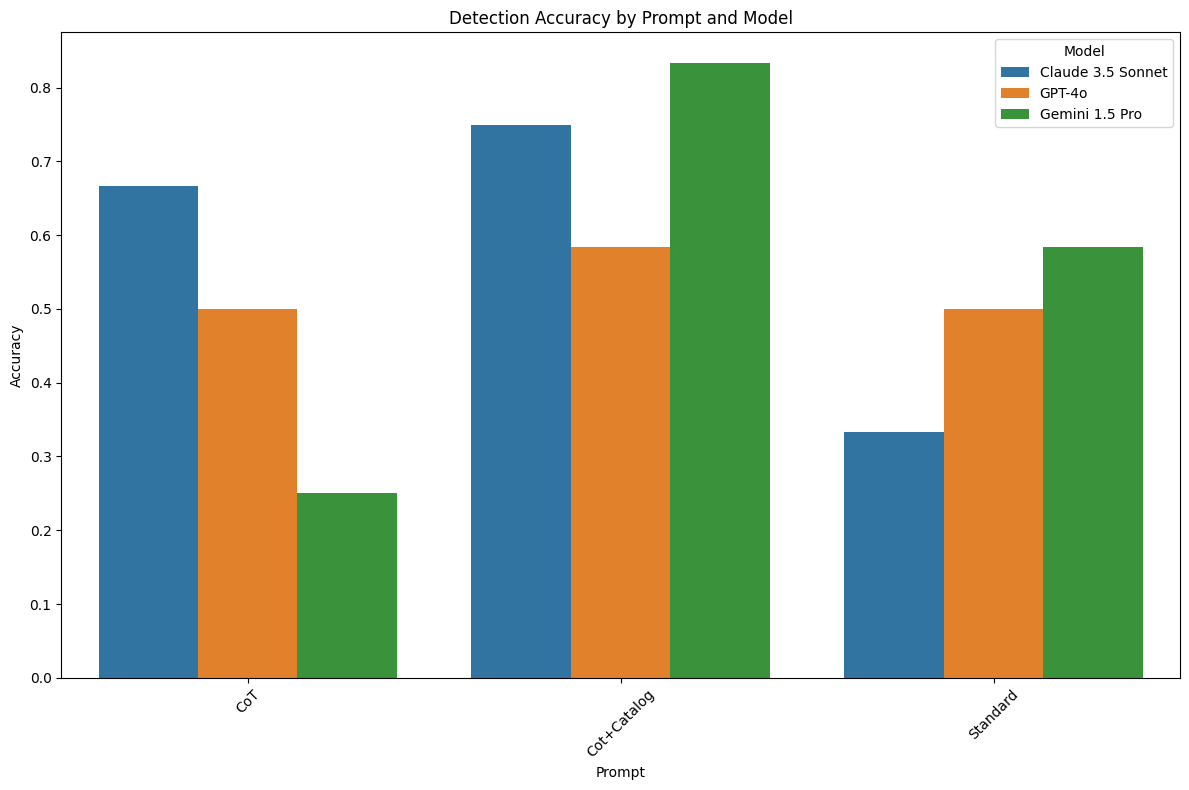

In [121]:
sns_data_prompt_model = df.groupby(['Prompt', 'Model'])['Detected'].mean().reset_index()


plt.figure(figsize=(12, 8))
sns.barplot(x='Prompt', y='Detected', hue='Model', data=sns_data_prompt_model)
plt.title('Detection Accuracy by Prompt and Model')
plt.xlabel('Prompt')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Detection Accuracy by Prompt

In [96]:
numeric_detected = df['Detected'].astype(int)

prompt_grouped_stats = df.groupby(['Prompt'])['Detected'].agg(['count', 'mean', 'std', 'var']).round(3)

prompt_grouped_stats

,count,mean,std,var
Prompt,,,,
CoT,36,0.472,0.506,0.256
Cot+Catalog,36,0.722,0.454,0.206
Standard,36,0.472,0.506,0.256


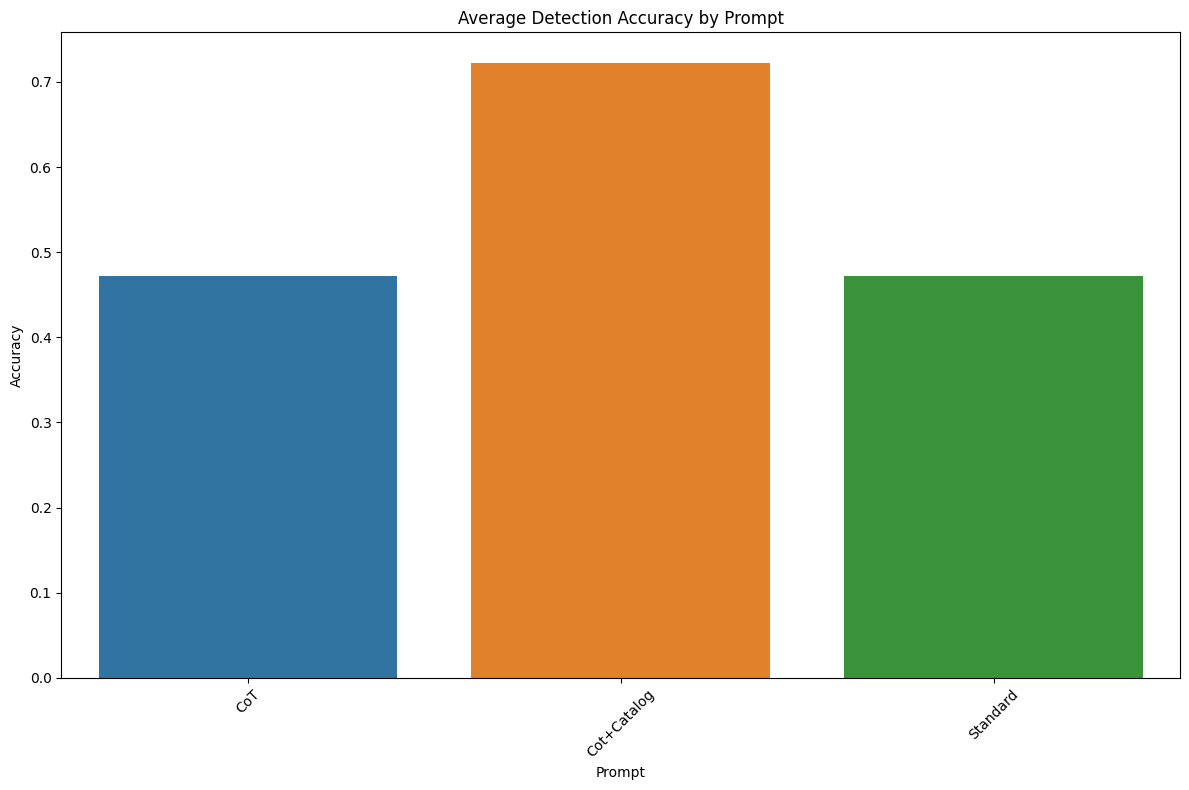

In [119]:
accuracy_prompt = df.groupby(["Prompt"])["Detected"].mean().reset_index()

prompt_order = ['Standard', 'CoT', 'CoT+Catalog']


plt.figure(figsize=(12, 8))
sns.barplot(x='Prompt', y='Detected', hue="Prompt", data=accuracy_prompt,)
plt.title('Average Detection Accuracy by Prompt')
plt.xlabel('Prompt')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Detection Accuracy by Model

In [98]:
prompt_grouped_stanumeric_detected = df['Detected'].astype(int)

model_grouped_stats = df.groupby(['Model'])['Detected'].agg(['count', 'mean', 'std', 'var']).round(3)

model_grouped_stats

,count,mean,std,var
Model,,,,
Claude 3.5 Sonnet,36,0.583,0.500,0.250
GPT-4o,36,0.528,0.506,0.256
Gemini 1.5 Pro,36,0.556,0.504,0.254


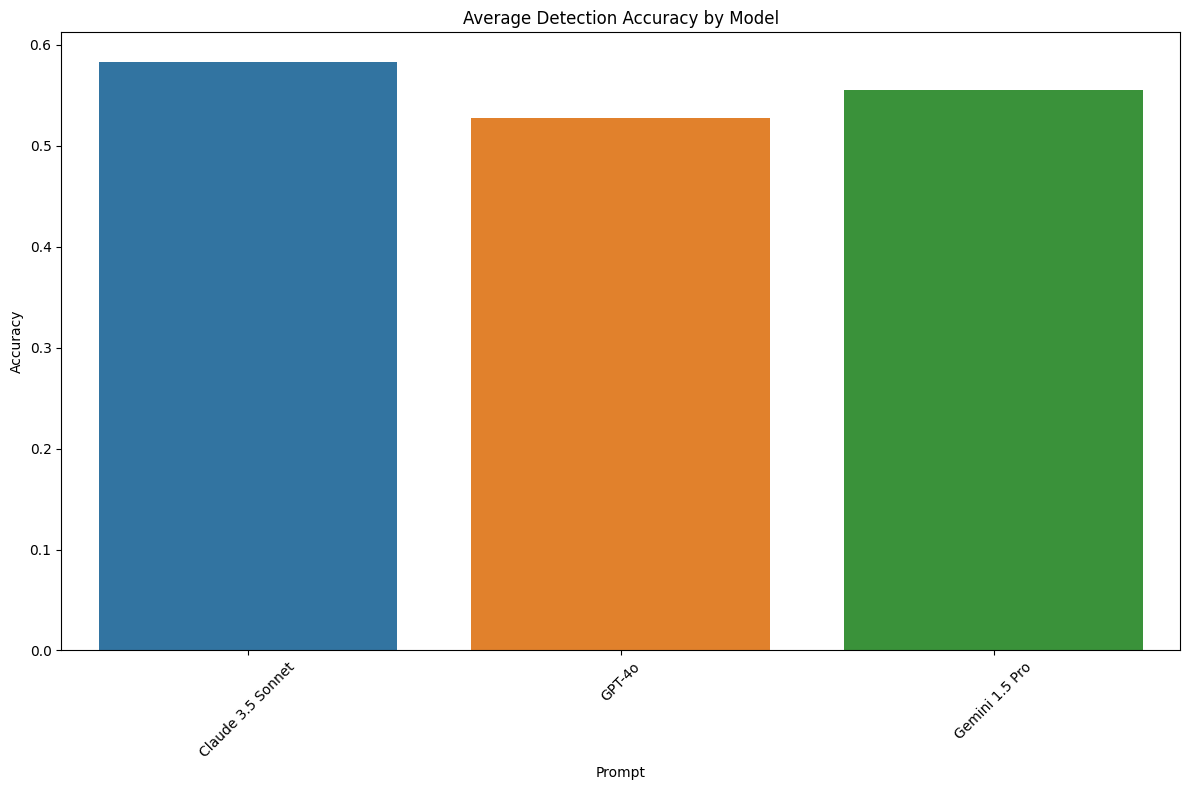

In [99]:
accuracy_prompt = df.groupby(["Model"])["Detected"].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Detected', hue="Model", data=accuracy_prompt)
plt.title('Average Detection Accuracy by Model')
plt.xlabel('Prompt')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Detection Accuracy by Antipattern

In [100]:
accuracy_stats_by_antipattern = df.groupby("Antipattern")["Detected"].agg(
    mean="mean", 
    std="std", 
    var="var"
).reset_index()

accuracy_stats_by_antipattern

,Antipattern,mean,std,var
0,API Versioning,0.500000,0.514496,0.264706
1,Ambigious Service,0.666667,0.485071,0.235294
2,Chatty Service,0.722222,0.460889,0.212418
3,Nanoservices,0.444444,0.511310,0.261438
4,Service Chain,0.222222,0.427793,0.183007
5,Shared Persistency,0.777778,0.427793,0.183007


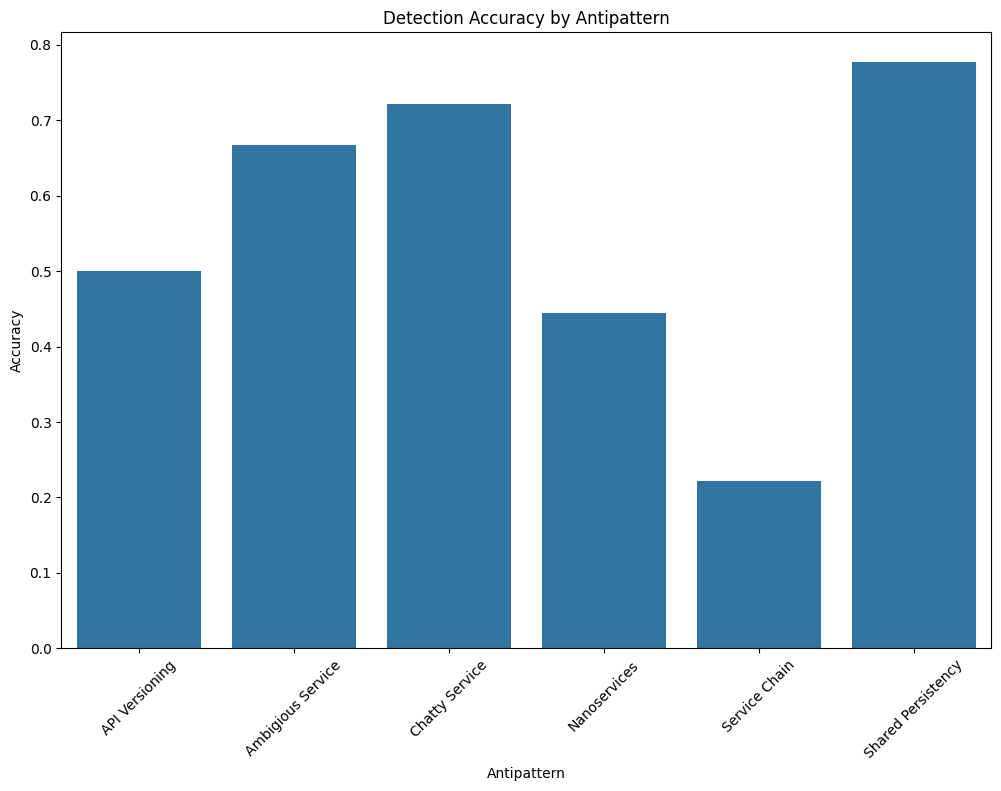

In [101]:
accuracy_by_antipattern = df.groupby("Antipattern")["Detected"].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='Antipattern', y='Detected', data=accuracy_by_antipattern)
plt.title('Detection Accuracy by Antipattern')
plt.xlabel("Antipattern")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

## Detection accuracy by input format

In [102]:
accuracy_stats_by_inputformat = df.groupby("InputFormat")["Detected"].agg(
    mean="mean", 
    std="std", 
    var="var"
).reset_index()

accuracy_stats_by_inputformat

,InputFormat,mean,std,var
0,OpenApi,0.583333,0.500000,0.250000
1,PlantUML Component Diagram,0.611111,0.494413,0.244444
2,PlantUML Sequence Diagram,0.472222,0.506309,0.256349


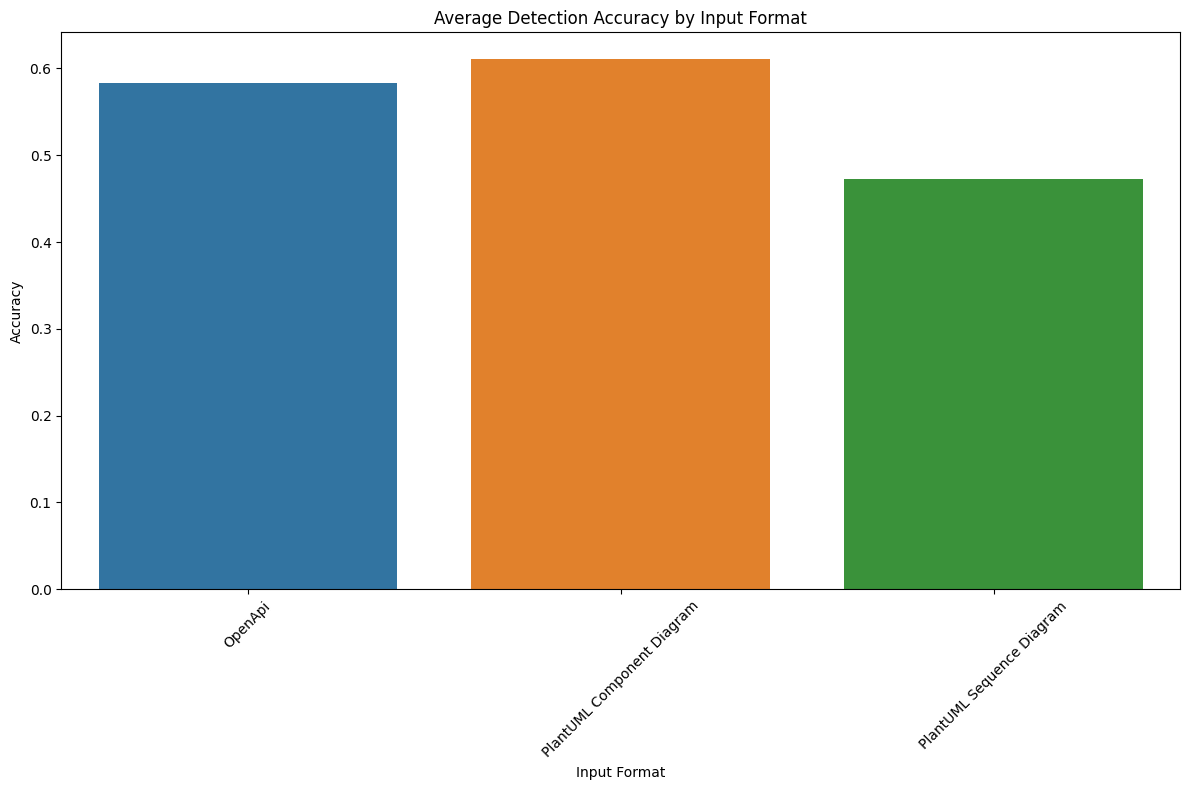

In [103]:
accuracy_prompt = df.groupby(["InputFormat"])["Detected"].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='InputFormat', y='Detected', hue="InputFormat", data=accuracy_prompt)
plt.title('Average Detection Accuracy by Input Format')
plt.xlabel('Input Format')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Improvement Quality by Prompt and Model

In [104]:
improvement_suggestion_df = df[df['ImprovementQuality'] > 0]

improvement_suggestion_mean = improvement_suggestion_df
improvement_suggestion_mean = improvement_suggestion_mean.groupby(['Prompt', 'Model'])['ImprovementQuality']
improvement_suggestion_mean = improvement_suggestion_mean.mean().reset_index()
improvement_suggestion_mean

,Prompt,Model,ImprovementQuality
0,CoT,Claude 3.5 Sonnet,2.750000
1,CoT,GPT-4o,2.500000
2,CoT,Gemini 1.5 Pro,3.000000
3,Cot+Catalog,Claude 3.5 Sonnet,2.555556
4,Cot+Catalog,GPT-4o,3.000000
5,Cot+Catalog,Gemini 1.5 Pro,2.800000
6,Standard,Claude 3.5 Sonnet,2.750000
7,Standard,GPT-4o,2.500000
8,Standard,Gemini 1.5 Pro,2.714286


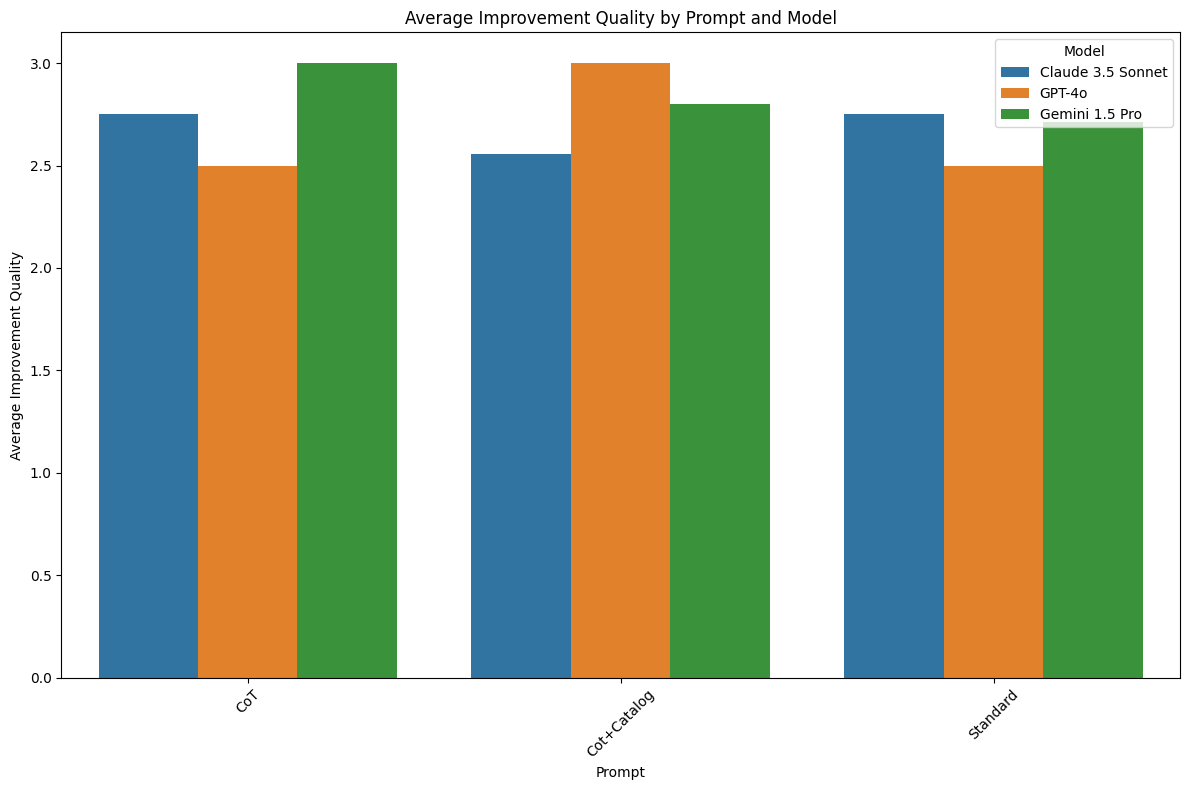

In [105]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Prompt', y='ImprovementQuality', hue='Model', data=improvement_suggestion_mean)
plt.title('Average Improvement Quality by Prompt and Model')
plt.xlabel('Prompt')
plt.ylabel('Average Improvement Quality')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [122]:
def quality_label(value):
    if value == 1:
        return 'Basic'
    elif value == 2:
        return 'Moderate'
    elif value == 3:
        return 'Insightful'
    
colors = {
    'Basic': 'darkred',
    'Moderate': 'orange',
    'Insightful': 'green'
}

improvement_suggestion_labeled = df[df['ImprovementQuality'] > 0]
improvement_suggestion_labeled['QualityLabel'] = improvement_suggestion_labeled['ImprovementQuality'].apply(quality_label)

/tmp/ipykernel_24895/2631305226.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  improvement_suggestion_labeled['QualityLabel'] = improvement_suggestion_labeled['ImprovementQuality'].apply(quality_label)


In [123]:
sum_by_label = improvement_suggestion_labeled.groupby(['QualityLabel']).size().reset_index(name='Count')

sum_by_label

,QualityLabel,Count
0,Basic,2
1,Insightful,45
2,Moderate,13


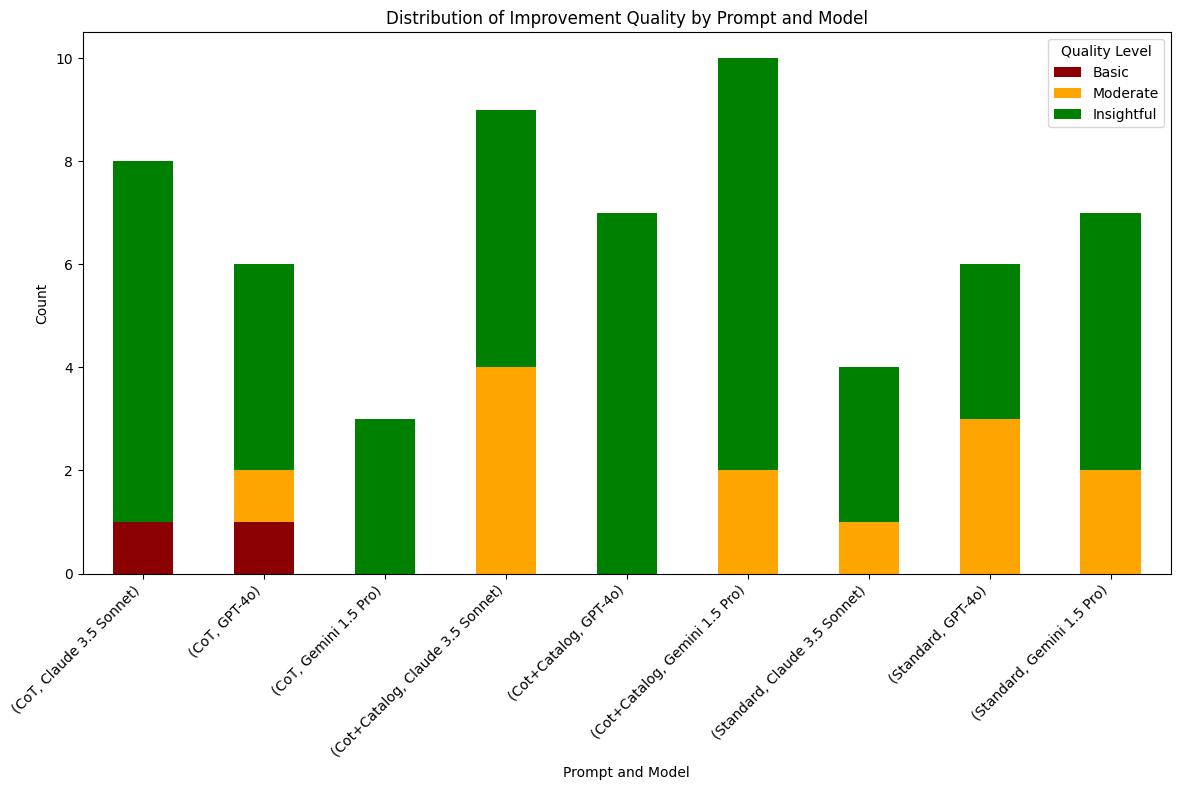

In [135]:
grouped = improvement_suggestion_labeled.groupby(['Prompt', 'Model', 'QualityLabel']).size().reset_index(name='Count')

pivot = grouped.pivot(index=['Prompt', 'Model'], columns='QualityLabel', values='Count').fillna(0)
pivot = pivot[['Basic', 'Moderate', 'Insightful']]

pivot.plot(kind='bar', stacked=True, figsize=(12, 8), color=[colors[col] for col in pivot.columns])
plt.title('Distribution of Improvement Quality by Prompt and Model')
plt.ylabel('Count')
plt.xlabel('Prompt and Model')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Quality Level')
plt.tight_layout()
plt.show()

## Improvement Quality by Model

In [127]:
quality_by_model = improvement_suggestion_df.groupby("Model")["ImprovementQuality"].mean().reset_index()
quality_by_model

,Model,ImprovementQuality
0,Claude 3.5 Sonnet,2.666667
1,GPT-4o,2.684211
2,Gemini 1.5 Pro,2.800000


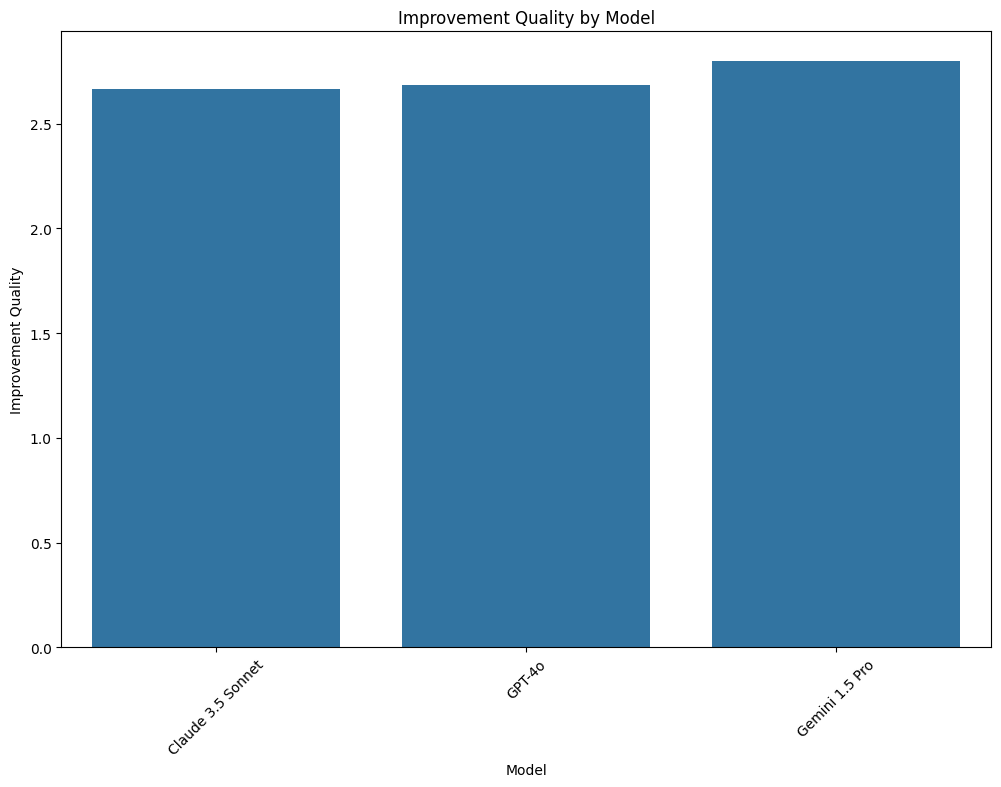

In [128]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='ImprovementQuality', data=quality_by_model)
plt.title('Improvement Quality by Model')
plt.xlabel("Model")
plt.ylabel("Improvement Quality")
plt.xticks(rotation=45)
plt.show()

## Improvement Quality by Prompt

In [129]:
quality_by_prompt = improvement_suggestion_df.groupby("Prompt")["ImprovementQuality"].mean().reset_index()
quality_by_prompt

,Prompt,ImprovementQuality
0,CoT,2.705882
1,Cot+Catalog,2.769231
2,Standard,2.647059


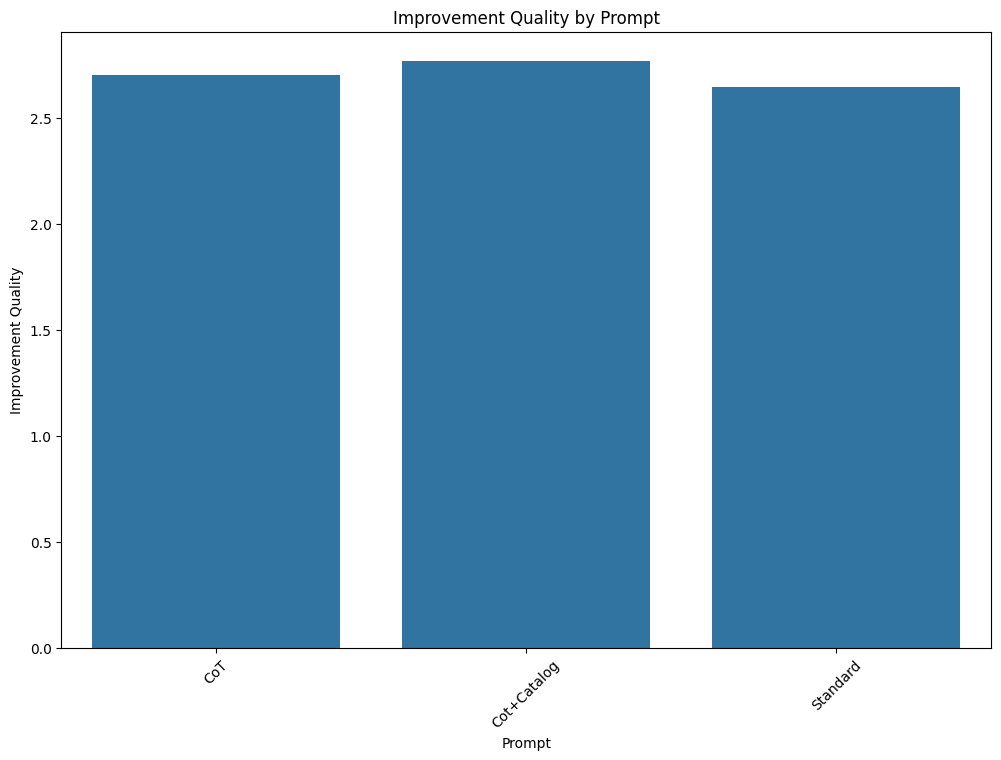

In [130]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Prompt', y='ImprovementQuality', data=quality_by_prompt)
plt.title('Improvement Quality by Prompt')
plt.xlabel("Prompt")
plt.ylabel("Improvement Quality")
plt.xticks(rotation=45)
plt.show()

## Improvement Quality by Antipattern

In [131]:
quality_by_antipattern = improvement_suggestion_df.groupby("Antipattern")["ImprovementQuality"].mean().reset_index()
quality_by_antipattern

,Antipattern,ImprovementQuality
0,API Versioning,2.888889
1,Ambigious Service,2.416667
2,Chatty Service,2.923077
3,Nanoservices,2.625000
4,Service Chain,1.750000
5,Shared Persistency,3.000000


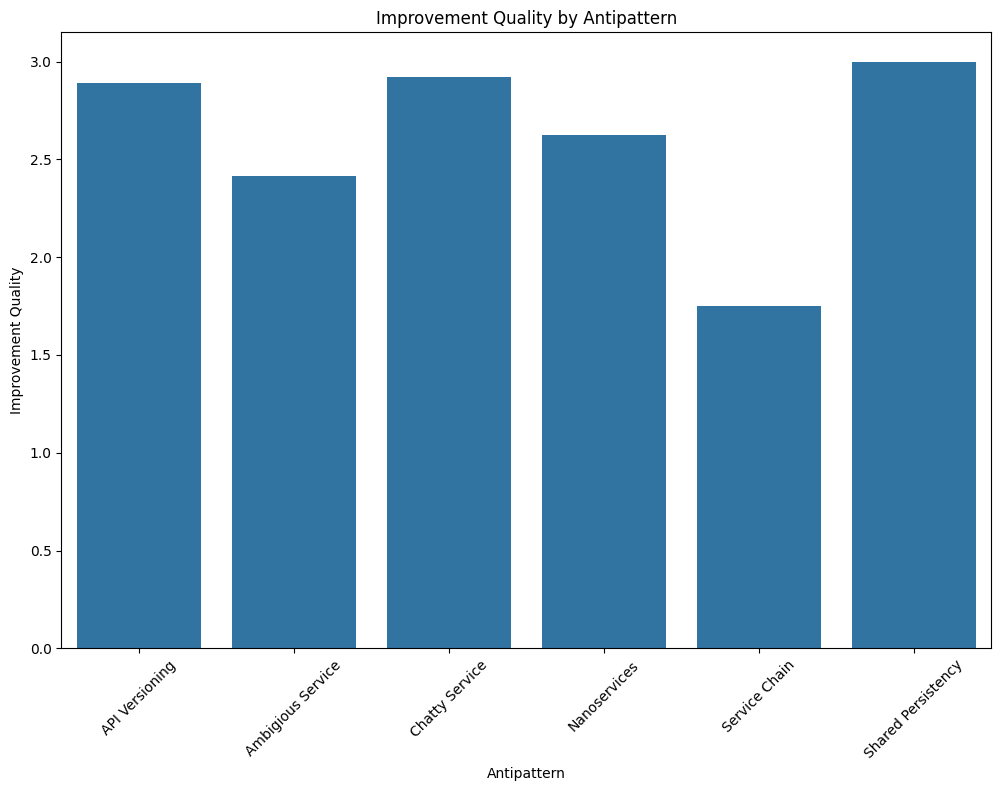

In [132]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Antipattern', y='ImprovementQuality', data=quality_by_antipattern)
plt.title('Improvement Quality by Antipattern')
plt.xlabel("Antipattern")
plt.ylabel("Improvement Quality")
plt.xticks(rotation=45)
plt.show()